## Setup

In [1]:
# pip install -q -U keras-tuner

In [2]:
# Load the TensorBoard notebook extension
# %load_ext tensorboard

In [3]:
# load libraries
import os
import cv2
import glob as glob
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Clear any logs from previous runs
os.system('rm -rf ./logs/')

1

In [5]:
data_dir = 'data\\images_original'

In [6]:
image_count = len(list(glob.iglob(data_dir + '/**/*.png', recursive=True)))
print(image_count)

999


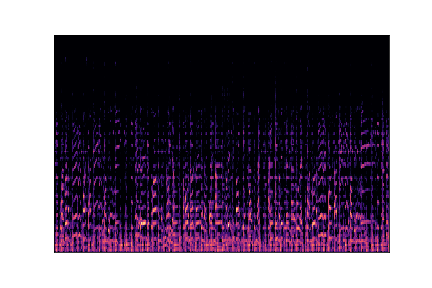

In [7]:
# load an image
blues = list(glob.iglob(data_dir + '/**/blueS/*.png', recursive=True))
PIL.Image.open(str(blues[0]))

## Create a dataset

In [8]:
# Parameters
batch_size = 32
img_width = 432
img_height = 288
image_size = (img_width, img_height)

Training & Testing Split

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 999 files belonging to 10 classes.
Using 800 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 999 files belonging to 10 classes.
Using 199 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [11]:
class_names = train_ds.class_names
print(class_names)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## Visualize the dataset

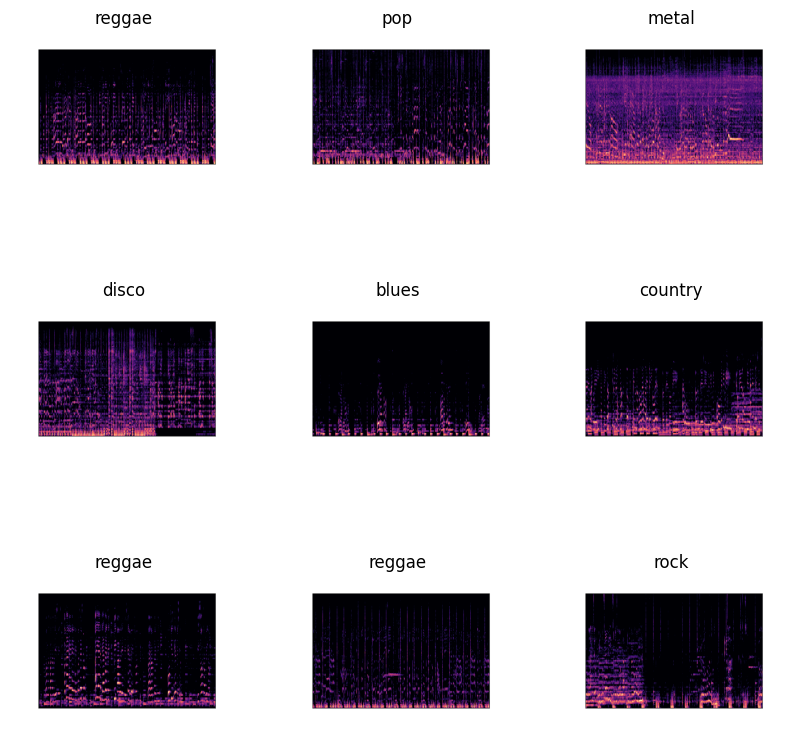

In [12]:
# Here are the first nine images from the training dataset:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 288, 432, 3)
(32,)


## Configure the Dataset for Performance

To ensure efficient data loading and prevent I/O from becoming a bottleneck, use buffered prefetching. Here are two essential methods to consider:

- **`Dataset.cache`**: This method caches the images in memory after they are loaded off disk during the first epoch. This prevents the dataset from becoming a bottleneck during model training. If your dataset is too large to fit into memory, you can use this method to create a performant on-disk cache.
  
- **`Dataset.prefetch`**: This method overlaps data preprocessing and model execution during training, improving overall performance.

For more details on these methods and how to cache data to disk, refer to the [Prefetching section of the Better Performance with the tf.data API guide](https://github.com/tensorflow/docs/blob/460419a6369bd00bfc3ce7a7c92b0ca2a832c91b/site/en/guide/data_performance.ipynb).

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## data augementation

In [15]:
# data_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip("horizontal",
#                           input_shape=(img_height,
#                                        img_width,
#                                        3)),  # Horizontal flip might be relevant for spectrograms
#         layers.RandomRotation(0.01),  # Smaller rotation range to avoid distorting time-frequency representation
#         layers.RandomZoom(0.05),  # Smaller zoom level to maintain the integrity of the spectrogram
#         layers.RandomContrast(0.01)  # Moderate contrast adjustment
#     ]
# )


Visualize a few augmented examples by applying data augmentation to the same image several times:

In [16]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")
     

## Model Training

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [17]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters

In [18]:
num_classes = len(class_names)

def build_model(hp):
    model = Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
    
    hp_units_1 = hp.Int('Conv2D_units_1', min_value=2, max_value=32, step=2)
    model.add(Conv2D(hp_units_1, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    
    hp_units_2 = hp.Int('Conv2D_units_2', min_value=2, max_value=32, step=2)
    model.add(Conv2D(hp_units_2, 3, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    
    hp_units_3 = hp.Int('Dense_units_1', min_value=32, max_value=64, step=2)
    model.add(Dense(hp_units_3, activation='relu'))
    # model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))

    hp_units_4 = hp.Int('Dense_units_2', min_value=2, max_value=32, step=2)
    model.add(Dense(hp_units_3, activation='relu'))
    
    model.add(Dense(num_classes, name="outputs"))
    
    # Refined learning rate options
    hp_learning_rate = hp.Choice('learning_rate', values=[0.0001,0.0025, 0.005, 0.001, 0.0025])
    
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model



In [19]:
# check gpu availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# check gpu memory usage
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt',
    overwrite=True)


In [21]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [22]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [23]:
tuner.search(train_ds, epochs=100, validation_data=val_ds, callbacks=[stop_early])

Trial 90 Complete [00h 00m 44s]
val_accuracy: 0.5125628113746643

Best val_accuracy So Far: 0.6381909251213074
Total elapsed time: 00h 15m 02s


In [24]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [25]:
print(f"""
units_1: {best_hps.get('Conv2D_units_1')},
units_2: {best_hps.get('Conv2D_units_2')},
units_3: {best_hps.get('Dense_units_1')},
units_4: {best_hps.get('Dense_units_2')},
learning rate: {best_hps.get('learning_rate')}.
""")


units_1: 18,
units_2: 20,
units_3: 46,
units_4: 20,
learning rate: 0.001.



In [47]:
stop_early_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [48]:
# reduce learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2,
                              patience=10,
                              cooldown=2,
                              min_lr=0.0001)

In [49]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[stop_early_1, reduce_lr])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
25/25 [==============================] - 2s 59ms/step - loss: 3.3609 - accuracy: 0.0850 - val_loss: 2.2948 - val_accuracy: 0.1206 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 1s 55ms/step - loss: 2.2611 - accuracy: 0.1688 - val_loss: 2.2243 - val_accuracy: 0.1658 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 1s 56ms/step - loss: 2.0566 - accuracy: 0.2713 - val_loss: 2.0427 - val_accuracy: 0.2211 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 1s 59ms/step - loss: 1.7246 - accuracy: 0.4225 - val_loss: 1.8239 - val_accuracy: 0.3367 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 1s 56ms/step - loss: 1.2262 - accuracy: 0.5850 - val_loss: 1.8180 - val_accuracy: 0.3116 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 1s 55ms/step - loss: 0.7956 - accuracy: 0.7613 - val_loss: 1.5393 - val_accuracy: 0.4271 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 1s 54ms/step - lo

In [50]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(train_ds, epochs=best_epoch, validation_data=val_ds, callbacks=[stop_early_1, reduce_lr])

Epoch 1/18
25/25 [==============================] - 2s 69ms/step - loss: 5.7176 - accuracy: 0.0988 - val_loss: 2.2973 - val_accuracy: 0.0905 - lr: 0.0010
Epoch 2/18
25/25 [==============================] - 1s 59ms/step - loss: 2.2833 - accuracy: 0.1425 - val_loss: 2.2895 - val_accuracy: 0.1457 - lr: 0.0010
Epoch 3/18
25/25 [==============================] - 1s 57ms/step - loss: 2.1499 - accuracy: 0.2262 - val_loss: 2.0891 - val_accuracy: 0.2312 - lr: 0.0010
Epoch 4/18
25/25 [==============================] - 1s 59ms/step - loss: 1.7245 - accuracy: 0.4487 - val_loss: 1.8547 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 5/18
25/25 [==============================] - 1s 59ms/step - loss: 1.1997 - accuracy: 0.6125 - val_loss: 1.5352 - val_accuracy: 0.4724 - lr: 0.0010
Epoch 6/18
25/25 [==============================] - 1s 57ms/step - loss: 0.7011 - accuracy: 0.8012 - val_loss: 1.3396 - val_accuracy: 0.5377 - lr: 0.0010
Epoch 7/18
25/25 [==============================] - 1s 55ms/step - loss: 0.3

In [51]:
eval_result = hypermodel.evaluate(val_ds)
print("[val loss, val accuracy]:", eval_result)

1/7 [===>..........................] - ETA: 0s - loss: 1.2771 - accuracy: 0.6250

7/7 [==============================] - 0s 18ms/step - loss: 1.3396 - accuracy: 0.5377
[val loss, val accuracy]: [1.3396023511886597, 0.5376884341239929]


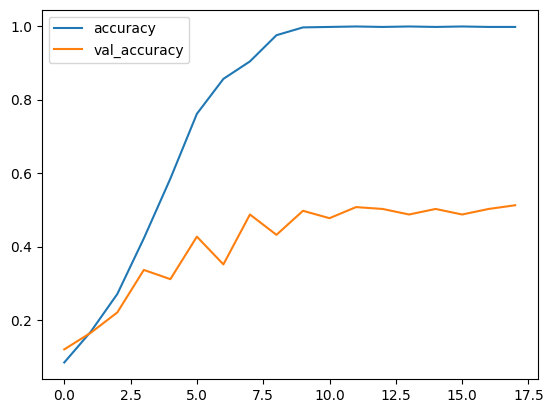

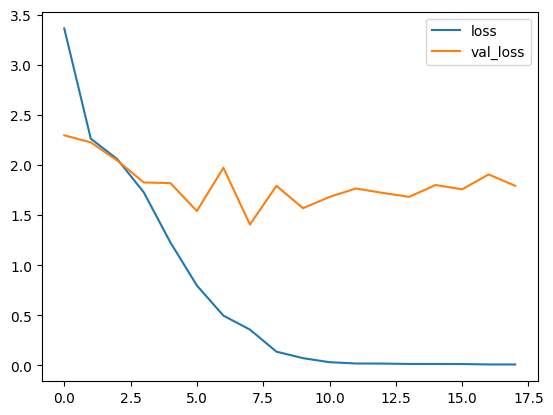

In [52]:
# plot the loss and accuracy
plt.plot(model.history.history['accuracy'], label='accuracy')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

plt.plot(model.history.history['loss'], label='loss')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [53]:
# %tensorboard --logdir logs/fit

In [54]:
# save the cnn model
# model.save('models\\cnn_model.h5')